In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion, TransformerMixin
import gc
from os import path
from sklearn.preprocessing import LabelEncoder
from pandas.core.dtypes.dtypes import CategoricalDtype
from tqdm import tqdm
from datetime import date 
import holidays
import lightgbm as lgb


warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

# label encoding
le = LabelEncoder()

In [2]:
class ConvertToDatetime(TransformerMixin):
        
    def transform(self, df, **transform_params):
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df

    def fit(self, X, y=None, **fit_params):
        return self

In [3]:
file_dtype = {
    'train': {'building_id': np.int16, 'meter': np.int8, 'meter_reading': np.float32},
    'test': {'building_id': np.int16, 'meter': np.int8},
    'building_metadata': {'site_id': np.int8, 'building_id': np.uint16, 'square_feet': np.float32, 'year_built': np.float16, 'floor_count': np.float16},
}

def loadFile(name):
    for dir_path in ['../input/ashrae-energy-prediction/','../input/_ashrae-energy-prediction/']:
        if path.exists(dir_path + name + '.csv'):
            return  ConvertToDatetime().transform(
                pd.read_csv(dir_path + name + '.csv', dtype=file_dtype[name]))
        


In [4]:
train = loadFile('train')

In [5]:
# "As you can see above, this data looks weired until May 20. It is 
# reported in this discussion by @barnwellguy that All electricity
# meter is 0 until May 20 for site_id == 0. Let's remove these data 
# from training data."
# https://www.kaggle.com/kaushal2896/ashrae-eda-fe-lightgbm-1-13
class RmS0M0(TransformerMixin):
  
    def transform(self, df, **transform_params):
        return df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

    def fit(self, X, y=None, **fit_params):
        return self



In [6]:
# following this thread
# https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113254#latest-663021
class RmBuilt2017(TransformerMixin):
# TO  
    def transform(self, df, **transform_params):
        # 954 leading zeros
        df = df.query('not (building_id == 954 & timestamp <= "2016-08-12")')
        df = df.query('not (building_id == 954 & timestamp <= "2016-10-12" & timestamp >= "2016-10-18")')
        
        return df

    def fit(self, X, y=None, **fit_params):
        return self
    

In [7]:
# remove big offenders in the error analysis reports
# https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113254#latest-663021
class RmEAOffeners(TransformerMixin):
# TO  
    def transform(self, df, **transform_params):
        # 1072 new steam install
        df = df.query('not (building_id == 1072 & timestamp <= "2016-10-12" & timestamp >= "2016-10-18")')
        
        # 783
        df = df.query('not (building_id == 783 & timestamp <= "2016-12-09" & timestamp >= "2016-10-18")')
        
        # 1264
        # not sure what to do with that one
        
        # 1021
        # drop zeros for hot water
        
        # 799
        df = df.query('not (building_id == 799 & meter == 0 & timestamp <= "2016-09-12")')
        
        # 693
        df = df.query('not (building_id == 693 & meter == 0 & timestamp <= "2016-07-11")')
        
        return df

    def fit(self, X, y=None, **fit_params):
        return self


In [8]:
class MeterReadingLog1p(TransformerMixin):
  
    def transform(self, df, **transform_params):
        if 'meter_reading' in df.columns:
            df['meter_reading_log1p'] = np.log1p(df['meter_reading'])
            df = df.drop('meter_reading', axis=1)
        return df
    
    def fit(self, X, y=None, **fit_params):
        return self
print(train.sample(20, random_state=42))
print(MeterReadingLog1p().transform(train.sample(20, random_state=42)))
gc.collect()

          building_id  meter           timestamp  meter_reading
14245562         1324      1 2016-09-16 16:00:00       0.000000
1282718          1013      0 2016-01-24 06:00:00      32.000099
13883790          229      1 2016-09-10 07:00:00     567.655029
4781820           217      3 2016-04-01 01:00:00       0.000000
10415393         1434      0 2016-07-10 04:00:00      65.750000
1057008          1047      0 2016-01-20 04:00:00      90.983299
4507399           911      1 2016-03-26 20:00:00     295.063995
19478829         1039      0 2016-12-18 23:00:00      16.900000
8955615           265      0 2016-06-14 06:00:00     128.369995
13799839          896      0 2016-09-08 19:00:00     300.000000
15647011          973      0 2016-10-11 11:00:00     247.000000
2524294           813      0 2016-02-16 08:00:00      10.958300
10016102          870      0 2016-07-03 02:00:00       4.166700
3915750           898      0 2016-03-15 03:00:00      40.000000
17217526          903      0 2016-11-08 

35

In [9]:
class AddTimeFeatures(TransformerMixin):
        
    def transform(self, df_a, **transform_params):
        # TODO: try week of year as numerical 
        df = df_a
        df['dayofweek'] = df['timestamp'].dt.dayofweek.astype('uint8') # vs weekend?
        #df['weekday'] = df['timestamp'].dt.weekday.astype('category')
        #df['dayofweek_hour'] = (df['timestamp'].dt.dayofweek * 24) + df['timestamp'].dt.hour
        #df['dayofweek_hour'] = df['dayofweek_hour'].astype('category')
        #df['week'] = df['timestamp'].dt.week.astype('category')
        df['hour'] = df['timestamp'].dt.hour.astype('uint8')
        return df
        
    def fit(self, X, y=None, **fit_params):
        return self

In [10]:
class CreateMeterHDDescDF(TransformerMixin):

    def transform(self, df, **transform_params):
        global _m_dow_desc_DF
        if 'meter_reading_log1p' in df.columns:
            group = df[['building_id','meter','dayofweek','hour','meter_reading_log1p']].groupby(['building_id','meter','dayofweek','hour'])['meter_reading_log1p']
            desc_DF = group.describe()
            desc_DF = desc_DF.reset_index()
            col_dict = {}
            for col in desc_DF.columns:
                if col not in ['building_id', 'meter', 'count','hour','dayofweek']:
                    col_dict[col] = 'meter_h_d_' + col
            return desc_DF.rename(columns=col_dict).drop('count', axis=1)
            gc.collect()
        return df 
    def fit(self, X, y=None, **fit_params):
        return self

#if 'meter_mean' not in train.columns:
#    print(building_meter_desc_DF)
#    train = train.merge(building_meter_desc_DF, on=['building_id','meter'], how='left')
#    #test = test.merge(building_meter_desc_DF, on=['building_id','meter'], how='left')
#    del building_meter_desc_DF


In [11]:
x_pre_pipes = Pipeline(
    steps=[       
        ('rmS0M0', RmS0M0()),
        ('rmBuilt2017', RmBuilt2017()),
        ('RmEAOffeners', RmEAOffeners()),
        ('meterReadingLog1p',MeterReadingLog1p()),
        ('addTimeFeatures', AddTimeFeatures()),
        ('createMeterHDDescDF',CreateMeterHDDescDF())
    ]
)



In [12]:
m_h_d_df = x_pre_pipes.transform(train)
#_m_dow_desc_DF = reduce_mem_usage(_m_dow_desc_DF)
cols =  [x for x in m_h_d_df.columns if x not in ['building_id', 'meter', 'dayofweek','hour']]
for col in cols:
    print(col)
    m_h_d_df[col] = m_h_d_df[col].astype(np.float32)

meter_h_d_mean
meter_h_d_std
meter_h_d_min
meter_h_d_25%
meter_h_d_50%
meter_h_d_75%
meter_h_d_max


In [13]:
print(m_h_d_df.loc[m_h_d_df.isna().any(axis=1)])
m_h_d_df = m_h_d_df.fillna(0)

       building_id  meter  dayofweek  hour  meter_h_d_mean  meter_h_d_std  \
10825           53      0          5    20        5.951491            NaN   
10826           53      0          5    21        5.277803            NaN   
10827           53      0          5    22        0.000000            NaN   
10828           53      0          5    23        0.000000            NaN   

       meter_h_d_min  meter_h_d_25%  meter_h_d_50%  meter_h_d_75%  \
10825       5.951491       5.951491       5.951491       5.951491   
10826       5.277803       5.277803       5.277803       5.277803   
10827       0.000000       0.000000       0.000000       0.000000   
10828       0.000000       0.000000       0.000000       0.000000   

       meter_h_d_max  
10825       5.951491  
10826       5.277803  
10827       0.000000  
10828       0.000000  


each of these should have 24 hours
building_id  meter  dayofweek
53           0      3            1
                    5            4
Name: hour, dtype: int64


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


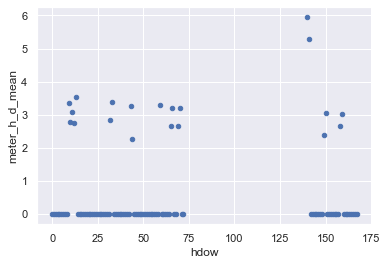

In [14]:
# Site 53 meter 0 doens't have readings for some hours
#group = m_h_d_df.groupby(['building_id','meter'])['hour'].count()
#sparse_group = group[group < 168]
#print(sparse_group)
group = m_h_d_df.groupby(['building_id','meter','dayofweek'])['hour'].count()
sparse_group = group[group < 7]
print("each of these should have 24 hours")
print(sparse_group)

#print(m_h_d_df[(m_h_d_df['building_id'] == 53) & (m_h_d_df['dayofweek'] == 3)])
#print(m_h_d_df[(m_h_d_df['building_id'] == 53) & (m_h_d_df['dayofweek'] == 5)])

f3_df = m_h_d_df.loc[m_h_d_df['building_id'] == 53, ['building_id','dayofweek','hour','meter_h_d_mean']]
f3_df['hdow'] =  f3_df['hour'] + (f3_df['dayofweek'] * 24)  
#print(f3_df[['hdow','meter_h_d_mean']])
f3_df[['meter_h_d_mean','hdow']].plot(kind='scatter', x='hdow',y='meter_h_d_mean')

             meter  dayofweek       hour  meter_h_d_mean  meter_h_d_std  \
building_id                                                               
53               0   2.366337  11.782178        0.640335       0.755456   

             meter_h_d_min  meter_h_d_25%  meter_h_d_50%  meter_h_d_75%  \
building_id                                                               
53                0.111181       0.364556       0.617932       0.904911   

             meter_h_d_max  
building_id                 
53                1.191891  
[0]
[]
[20.0, 21.0, 22.0, 23.0]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


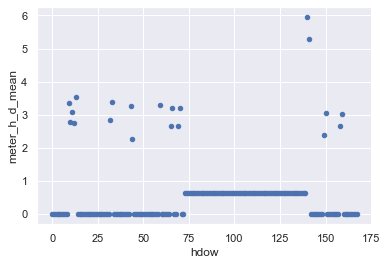

In [15]:
# populate missing values based off the graph going to populate day 3-5 thinking we might als
f3_mean_df = m_h_d_df[m_h_d_df['building_id'] == 53].groupby('building_id').mean()
print(f3_mean_df)
#print(m_h_d_df[(m_h_d_df['building_id'] == 53) & (m_h_d_df['dayofweek'] == 3)]['hour'].tolist())
for i in [3, 4, 5]:
    has_data_in_hour = m_h_d_df[(m_h_d_df['building_id'] == 53) & (m_h_d_df['dayofweek'] == i)]['hour'].tolist()
    print(has_data_in_hour)
    missing_hour = list(x for x in range(24) if x not in has_data_in_hour)
    for j in missing_hour:
        temp_df = f3_mean_df.reset_index()
        temp_df['dayofweek'] = i
        temp_df['hour'] = j
        m_h_d_df = m_h_d_df.append(temp_df)
        

    
group = m_h_d_df.groupby(['building_id','meter','dayofweek'])['hour'].count()
sparse_group = group[group < 7]
f3_df = m_h_d_df.loc[m_h_d_df['building_id'] == 53, ['building_id','dayofweek','hour','meter_h_d_mean']]
f3_df['hdow'] =  f3_df['hour'] + (f3_df['dayofweek'] * 24)  
f3_df[['meter_h_d_mean','hdow']].plot(kind='scatter', x='hdow',y='meter_h_d_mean')

In [16]:

#m_h_d_df.to_csv('derived_data/desc_h_dow.csv')
m_h_d_df.to_pickle('../input/ashrae-energy-prediction-pickles/desc_h_dow.pickle')

In [17]:
m_h_d_df.isna().any()

building_id       False
meter             False
dayofweek         False
hour              False
meter_h_d_mean    False
meter_h_d_std     False
meter_h_d_min     False
meter_h_d_25%     False
meter_h_d_50%     False
meter_h_d_75%     False
meter_h_d_max     False
dtype: bool